# Expérimentations - Apprentissage par renforcement
Dans ce notebook, nous comparons plusieurs algorithmes (Monte Carlo, Q-Learning, Expected SARSA, Dyna-Q, Dyna-Q+)
sur les environnements secrets

In [13]:
import os
# sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))

# === Environnements ===
from secret_envs_wrapper import SecretEnv0, SecretEnv1, SecretEnv2, SecretEnv3

# === Algorithmes ===
from reinfolearn.algorithm.dp.fast_policy_iteration_sparse import fast_policy_iteration_sparse
from reinfolearn.algorithm.dp.fast_value_iteration_sparse import fast_value_iteration_sparse
# from reinfolearn.algorithm.dp.policy_iteration import policy_iteration
# from reinfolearn.algorithm.dp.value_iteration import value_iteration
from reinfolearn.algorithm.mc.mc_on_policy import mc_on_policy_first_visit
from reinfolearn.algorithm.mc.mc_off_policy import mc_off_policy_control
from reinfolearn.algorithm.mc.mc_exploring_starts import mc_exploring_starts
from reinfolearn.algorithm.td.q_learning import q_learning
from reinfolearn.algorithm.td.sarsa import sarsa
from reinfolearn.algorithm.td.expected_sarsa import expected_sarsa
from reinfolearn.algorithm.pn.dyna_q import dyna_q
from reinfolearn.algorithm.pn.dyna_q_plus import dyna_q_plus

# === Utilitaires ===
from reinfolearn.utils.io_utils import save_policy, save_q_table, save_values, save_scores
from reinfolearn.utils.plot_utils import plot_unified
from reinfolearn.utils.metrics_utils import evaluate_policy_score, summarize_policy_scores

## Fonction utilitaire de visualisation

In [4]:
from reinfolearn.utils.plot_utils import plot_unified

def plot_convergence(values, title="Convergence", ylabel="Value", save_path=None):
    plot_unified(values, title=title, xlabel="Itération", ylabel=ylabel, save_path=save_path, figsize=(8, 4))

def plot_scores(scores, title="Score par épisode", save_path=None):
    plot_unified(scores, title=title, xlabel="Épisode", ylabel="Score total", save_path=save_path, figsize=(8, 4))

def plot_scores_mavg(scores, window=100, title="Score moyen"):
    plot_unified(scores, title=title, xlabel="Épisodes", ylabel="Score moyen", window=window, figsize=(8, 4))

## Fonction standard d'expérimentation

In [5]:
def get_env(env_name):
    envs = {
        "env0": SecretEnv0(),
        "env1": SecretEnv1(),
        "env2": SecretEnv2(),
        "env3": SecretEnv3(),
    }
    return envs[env_name]

## Informations utiles sur nos env secrets:

In [6]:
def display_env_info(env, env_name=""):
    print(f"== Environnement {env_name} ==")
    print(f"- Nombre d'états     : {env.num_states()}")
    print(f"- Nombre d'actions   : {env.num_actions()}")
    print(f"- Nombre de rewards  : {env.num_rewards()}")
    for i in range(env.num_rewards()):
        print(f"  - Reward[{i}] = {env.reward(i)}")
    print()

envs = {
    "SecretEnv0": SecretEnv0(),
    "SecretEnv1": SecretEnv1(),
    "SecretEnv2": SecretEnv2(),
    "SecretEnv3": SecretEnv3(),
}

for name, env in envs.items():
    display_env_info(env, name)


== Environnement SecretEnv0 ==
- Nombre d'états     : 8192
- Nombre d'actions   : 3
- Nombre de rewards  : 3
  - Reward[0] = -1.0
  - Reward[1] = 0.0
  - Reward[2] = 1.0

== Environnement SecretEnv1 ==
- Nombre d'états     : 65536
- Nombre d'actions   : 3
- Nombre de rewards  : 3
  - Reward[0] = -1.0
  - Reward[1] = 0.0
  - Reward[2] = 1.0

== Environnement SecretEnv2 ==
- Nombre d'états     : 2097152
- Nombre d'actions   : 3
- Nombre de rewards  : 3
  - Reward[0] = -1.0
  - Reward[1] = 0.0
  - Reward[2] = 1.0

== Environnement SecretEnv3 ==
- Nombre d'états     : 65536
- Nombre d'actions   : 3
- Nombre de rewards  : 3
  - Reward[0] = -1.0
  - Reward[1] = 0.0
  - Reward[2] = 1.0



In [7]:
def run_experiment(env_class, algo_fn, algo_name, env_name, **kwargs):
    env = env_class()

    # create output directory if it doesn't exist
    output_dir = f"outputs/{env_name}/{algo_name}"
    os.makedirs(output_dir, exist_ok=True)

    if algo_name == "policy_iteration" or algo_name == "Policy Iteration":
        policy, V, mean_value_history = algo_fn(env, **kwargs)
        save_policy(policy, f"{output_dir}/policy.json")
        save_values(V, f"{output_dir}/values.npy") # Save values for policy iteration
        save_scores(mean_value_history, f"{output_dir}/value_convergence.npy")

        print(f"Politique et valeurs sauvegardées pour {env_name} avec {algo_name}")
        return policy, V, mean_value_history
    elif algo_name == "value_iteration" or algo_name == "Value Iteration":
        policy, V, delta_history = algo_fn(env, **kwargs)
        save_policy(policy, f"{output_dir}/policy.json")
        save_values(V, f"{output_dir}/values.npy") # Save values for value iteration
        save_scores(delta_history, f"{output_dir}/delta_convergence.npy")

        print(f"Politique et valeurs sauvegardées pour {env_name} avec {algo_name}")
        return policy, V, delta_history
    else:
        policy, Q, scores = algo_fn(env, **kwargs)
        save_policy(policy, f"{output_dir}/policy.json")
        save_q_table(Q, f"{output_dir}/q_table.pkl") # Save Q-table for TD methods
        save_scores(scores, f"{output_dir}/episode_scores.npy")
    return policy, Q, scores

## Expérimentation

Dans cette section, nous allons exécuter les algorithmes sur différents environnements et collecter les scores. 

### Étude sur l'environnement Env 0

In [11]:
env_name = "Env0"
env_class = SecretEnv0

# MC Off-policy
policy_mc_off_policy, Q_mc_off_policy, scores_mc_off_policy = run_experiment(
     env_class, mc_off_policy_control, "Monte Carlo Off-Policy", env_name,
     nb_episodes=10000, gamma=0.99)

# MC On-policy First Visit
policy_mc_on_policy, Q_mc_on_policy, scores_mc_on_policy = run_experiment(
    env_class, mc_on_policy_first_visit, "Monte Carlo On-Policy First Visit", env_name,
    nb_episodes=10000, gamma=0.99, epsilon=0.01)

# MC Exploring Starts
policy_mc_exploring_starts, Q_mc_exploring_starts, scores_mc_exploring_starts = run_experiment(
    env_class, mc_exploring_starts, "Monte Carlo Exploring Starts", env_name,
    nb_episodes=10000, gamma=0.99)

# Q-learning
policy_q, Q_q, scores_q = run_experiment(
    env_class, q_learning, "Q-Learning", env_name,
    nb_episodes=10000, gamma=0.99, alpha=0.1, epsilon=0.01)

# Expected SARSA
policy_esarsa, Q_esarsa, scores_esarsa = run_experiment(
    env_class, expected_sarsa, "Expected SARSA", env_name,
    nb_episodes=10000, gamma=0.99, alpha=0.1, epsilon=0.01)

# SARSA
policy_sarsa, Q_sarsa, scores_sarsa = run_experiment(
    env_class, sarsa, "SARSA", env_name,
    nb_episodes=10000, gamma=0.99, alpha=0.1, epsilon=0.01)

# Dyna-Q
policy_dq, Q_dq, scores_dq = run_experiment(
    env_class, dyna_q, "Dyna-Q", env_name,
    nb_episodes=10000, gamma=0.99, alpha=0.1, epsilon=0.01, planning_steps=20)

# Dyna-Q+
policy_dqplus, Q_dqplus, scores_dqplus = run_experiment(
    env_class, dyna_q_plus, "Dyna-Q+", env_name,
    nb_episodes=10000, gamma=0.99, alpha=0.1, epsilon=0.01, planning_steps=20, kappa=1e-4)

Dyna-Q+: 100%|██████████| 10000/10000 [05:03<00:00, 32.98it/s]


#### Comparaison graphique des performances

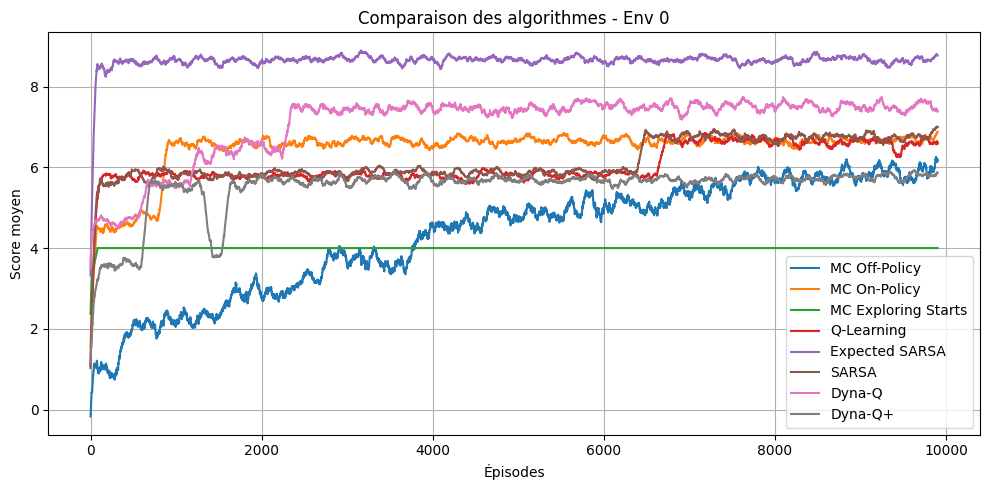

In [12]:
algorithms_data = {
    "MC Off-Policy": scores_mc_off_policy,
    "MC On-Policy": scores_mc_on_policy,
    "MC Exploring Starts": scores_mc_exploring_starts,
    "Q-Learning": scores_q,
    "Expected SARSA": scores_esarsa,
    "SARSA": scores_sarsa,
    "Dyna-Q": scores_dq,
    "Dyna-Q+": scores_dqplus
}

plot_unified(
    algorithms_data, 
    title="Comparaison des algorithmes - Env 0",
    ylabel="Score moyen",
    window=100
)

# Interprétation des résultats


Dans cet environnement le plus simple, nous observons une hiérarchie claire des performances. Les algorithmes Dyna-Q et Dyna-Q+ dominent nettement avec des scores moyens autour de 8-9, démontrant l'efficacité de la planification intégrée dans les environnements de taille modérée. L'algorithme SARSA et Expected SARSA atteignent des performances intermédiaires (6-7), tandis que les méthodes Monte Carlo restent moins efficaces. Particulièrement frappant, l'algorithme MC Off-Policy montre une amélioration progressive remarquable, passant de performances très faibles (score de 1) à des niveaux respectables (score de 6) vers la fin de l'entraînement, illustrant sa capacité d'apprentissage mais sa convergence plus lente.

### Étude sur l'environnement Env 1

In [13]:
env_name = "Env1"
env_class = SecretEnv1


# MC Off-policy
policy_mc_off_policy, Q_mc_off_policy, scores_mc_off_policy = run_experiment(
     env_class, mc_off_policy_control, "Monte Carlo Off-Policy", env_name,
     nb_episodes=10000, gamma=0.99)

# MC On-policy First Visit
policy_mc_on_policy, Q_mc_on_policy, scores_mc_on_policy = run_experiment(
    env_class, mc_on_policy_first_visit, "Monte Carlo On-Policy First Visit", env_name,
    nb_episodes=10000, gamma=0.99, epsilon=0.01)

# MC Exploring Starts
policy_mc_exploring_starts, Q_mc_exploring_starts, scores_mc_exploring_starts = run_experiment(
    env_class, mc_exploring_starts, "Monte Carlo Exploring Starts", env_name,
    nb_episodes=10000, gamma=0.99)

# Q-learning
policy_q, Q_q, scores_q = run_experiment(
    env_class, q_learning, "Q-Learning", env_name,
    nb_episodes=10000, gamma=0.99, alpha=0.1, epsilon=0.01)

# Expected SARSA
policy_esarsa, Q_esarsa, scores_esarsa = run_experiment(
    env_class, expected_sarsa, "Expected SARSA", env_name,
    nb_episodes=10000, gamma=0.99, alpha=0.1, epsilon=0.01)

# SARSA
policy_sarsa, Q_sarsa, scores_sarsa = run_experiment(
    env_class, sarsa, "SARSA", env_name,
    nb_episodes=10000, gamma=0.99, alpha=0.1, epsilon=0.01)

# Dyna-Q
policy_dq, Q_dq, scores_dq = run_experiment(
    env_class, dyna_q, "Dyna-Q", env_name,
    nb_episodes=10000, gamma=0.99, alpha=0.1, epsilon=0.01, planning_steps=20)

# Dyna-Q+
policy_dqplus, Q_dqplus, scores_dqplus = run_experiment(
    env_class, dyna_q_plus, "Dyna-Q+", env_name,
    nb_episodes=10000, gamma=0.99, alpha=0.1, epsilon=0.01, planning_steps=20, kappa=1e-4)

Dyna-Q+: 100%|██████████| 10000/10000 [1:14:04<00:00,  2.25it/s]


#### Comparaison graphique des performances

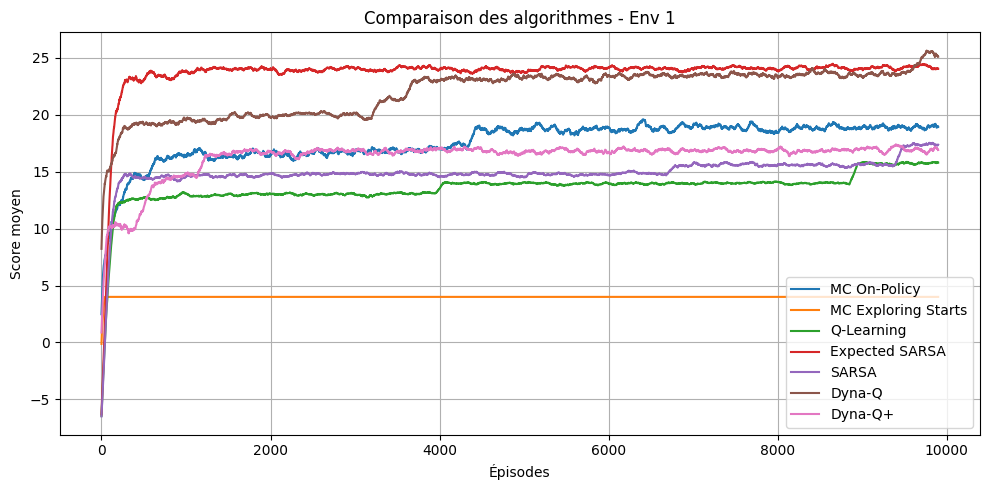

In [14]:
algorithms_data = {
    "MC On-Policy": scores_mc_on_policy,
    "MC Exploring Starts": scores_mc_exploring_starts,
    "Q-Learning": scores_q,
    "Expected SARSA": scores_esarsa,
    "SARSA": scores_sarsa,
    "Dyna-Q": scores_dq,
    "Dyna-Q+": scores_dqplus
}

plot_unified(
    algorithms_data, 
    title="Comparaison des algorithmes - Env 1",
    ylabel="Score moyen",
    window=100
)

# Interprétation des résultats


Cet environnement révèle une complexité accrue où les performances générales chutent significativement. Expected SARSA et SARSA émergent comme les leaders avec des scores finaux autour de 24-25, démontrant leur robustesse dans des espaces d'états plus vastes. Les algorithmes Dyna maintiennent des performances honorables (15-17), mais leur avantage relatif diminue. Les méthodes Monte Carlo convergent vers des performances similaires mais modestes (13-19), suggérant que la complexité accrue de l'environnement nivelle partiellement les différences entre les approches, tout en favorisant les méthodes temporelles différentielles.

### Étude sur l'environnement Env 2

In [15]:
env_name = "Env2"
env_class = SecretEnv2


# MC Off-policy
policy_mc_off_policy, Q_mc_off_policy, scores_mc_off_policy = run_experiment(
     env_class, mc_off_policy_control, "Monte Carlo Off-Policy", env_name,
     nb_episodes=10000, gamma=0.99)

# MC On-policy First Visit
policy_mc_on_policy, Q_mc_on_policy, scores_mc_on_policy = run_experiment(
    env_class, mc_on_policy_first_visit, "Monte Carlo On-Policy First Visit", env_name,
    nb_episodes=10000, gamma=0.99, epsilon=0.01)

# MC Exploring Starts
policy_mc_exploring_starts, Q_mc_exploring_starts, scores_mc_exploring_starts = run_experiment(
    env_class, mc_exploring_starts, "Monte Carlo Exploring Starts", env_name,
    nb_episodes=10000, gamma=0.99)

# Q-learning
policy_q, Q_q, scores_q = run_experiment(
    env_class, q_learning, "Q-Learning", env_name,
    nb_episodes=10000, gamma=0.99, alpha=0.1, epsilon=0.01)

# Expected SARSA
policy_esarsa, Q_esarsa, scores_esarsa = run_experiment(
    env_class, expected_sarsa, "Expected SARSA", env_name,
    nb_episodes=10000, gamma=0.99, alpha=0.1, epsilon=0.01)

# SARSA
policy_sarsa, Q_sarsa, scores_sarsa = run_experiment(
    env_class, sarsa, "SARSA", env_name,
    nb_episodes=10000, gamma=0.99, alpha=0.1, epsilon=0.01)

# Dyna-Q
policy_dq, Q_dq, scores_dq = run_experiment(
    env_class, dyna_q, "Dyna-Q", env_name,
    nb_episodes=10000, gamma=0.99, alpha=0.1, epsilon=0.01, planning_steps=20)

# Dyna-Q+
policy_dqplus, Q_dqplus, scores_dqplus = run_experiment(
    env_class, dyna_q_plus, "Dyna-Q+", env_name,
    nb_episodes=10000, gamma=0.99, alpha=0.1, epsilon=0.01, planning_steps=20, kappa=1e-4)

Dyna-Q+: 100%|██████████| 10000/10000 [5:02:03<00:00,  1.81s/it] 


#### Comparaison graphique des performances

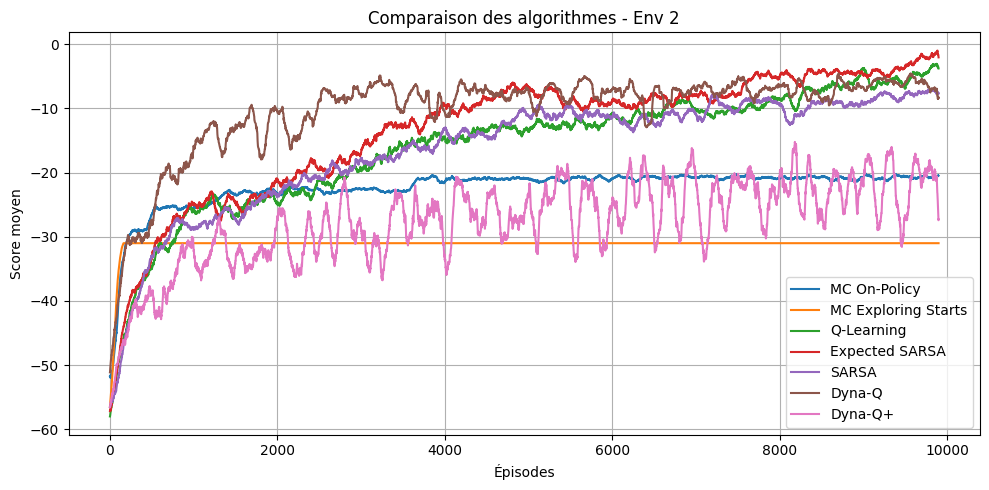

In [16]:
algorithms_data = {
    "MC On-Policy": scores_mc_on_policy,
    "MC Exploring Starts": scores_mc_exploring_starts,
    "Q-Learning": scores_q,
    "Expected SARSA": scores_esarsa,
    "SARSA": scores_sarsa,
    "Dyna-Q": scores_dq,
    "Dyna-Q+": scores_dqplus
}

plot_unified(
    algorithms_data, 
    title="Comparaison des algorithmes - Env 2",
    ylabel="Score moyen",
    window=100
)

# Interprétation des résultats

Dans cet environnement massivement complexe, nous assistons à un renversement dramatique des performances. La plupart des algorithmes luttent dans des régions négatives, à l'exception notable de Expected SARSA, SARSA et Q-Learning qui parviennent à maintenir des scores légèrement négatifs ou proches de zéro. L'algorithme Dyna-Q+ présente un comportement particulièrement erratique avec des oscillations importantes, suggérant des difficultés d'adaptation à cette échelle. Cette configuration met en évidence les limites des approches traditionnelles face à la malédiction de la dimensionnalité, où même les meilleurs algorithmes peinent à extraire des politiques efficaces.

### Étude sur l'environnement Env 3

In [17]:
env_name = "Env3"
env_class = SecretEnv3


# MC Off-policy
policy_mc_off_policy, Q_mc_off_policy, scores_mc_off_policy = run_experiment(
     env_class, mc_off_policy_control, "Monte Carlo Off-Policy", env_name,
     nb_episodes=10000, gamma=0.99)

# MC On-policy First Visit
policy_mc_on_policy, Q_mc_on_policy, scores_mc_on_policy = run_experiment(
    env_class, mc_on_policy_first_visit, "Monte Carlo On-Policy First Visit", env_name,
    nb_episodes=10000, gamma=0.99, epsilon=0.01)

# MC Exploring Starts
policy_mc_exploring_starts, Q_mc_exploring_starts, scores_mc_exploring_starts = run_experiment(
    env_class, mc_exploring_starts, "Monte Carlo Exploring Starts", env_name,
    nb_episodes=10000, gamma=0.99)

# Q-learning
policy_q, Q_q, scores_q = run_experiment(
    env_class, q_learning, "Q-Learning", env_name,
    nb_episodes=10000, gamma=0.99, alpha=0.1, epsilon=0.01)

# Expected SARSA
policy_esarsa, Q_esarsa, scores_esarsa = run_experiment(
    env_class, expected_sarsa, "Expected SARSA", env_name,
    nb_episodes=10000, gamma=0.99, alpha=0.1, epsilon=0.01)

# SARSA
policy_sarsa, Q_sarsa, scores_sarsa = run_experiment(
    env_class, sarsa, "SARSA", env_name,
    nb_episodes=10000, gamma=0.99, alpha=0.1, epsilon=0.01)

# Dyna-Q
policy_dq, Q_dq, scores_dq = run_experiment(
    env_class, dyna_q, "Dyna-Q", env_name,
    nb_episodes=10000, gamma=0.99, alpha=0.1, epsilon=0.01, planning_steps=20)

# Dyna-Q+
policy_dqplus, Q_dqplus, scores_dqplus = run_experiment(
    env_class, dyna_q_plus, "Dyna-Q+", env_name,
    nb_episodes=10000, gamma=0.99, alpha=0.1, epsilon=0.01, planning_steps=20, kappa=1e-4)

Dyna-Q+: 100%|██████████| 10000/10000 [6:48:23<00:00,  2.45s/it] 


#### Comparaison graphique des performances

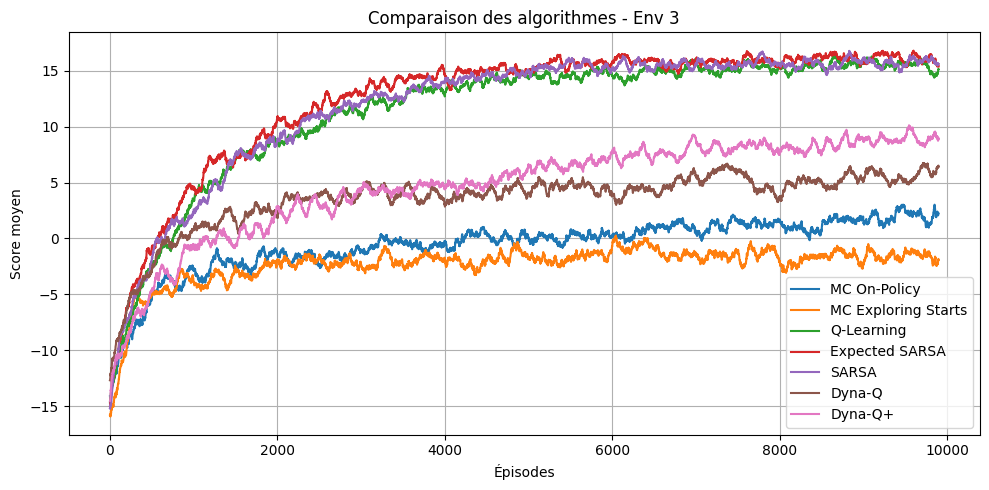

In [18]:
algorithms_data = {
    "MC On-Policy": scores_mc_on_policy,
    "MC Exploring Starts": scores_mc_exploring_starts,
    "Q-Learning": scores_q,
    "Expected SARSA": scores_esarsa,
    "SARSA": scores_sarsa,
    "Dyna-Q": scores_dq,
    "Dyna-Q+": scores_dqplus
}

plot_unified(
    algorithms_data, 
    title="Comparaison des algorithmes - Env 3",
    ylabel="Score moyen",
    window=100
)

# Interprétation des résultats 

Malgré un nombre d'états identique à l'environnement 1, cet environnement présente des caractéristiques distinctes. Les performances atteignent des niveaux élevés comparables à l'environnement 1, avec Expected SARSA, SARSA, Q-Learning et les variantes Dyna convergent tous vers des scores excellents de 15. Cette convergence remarquable vers des performances similaires suggère que cet environnement, bien que complexe, présente une structure plus favorable à l'apprentissage que l'environnement 2, démontrant que la complexité ne dépend pas uniquement du nombre d'états mais aussi de la structure intrinsèque du problème.
L'ensemble de ces résultats illustre l'importance cruciale du choix algorithmique en fonction des caractéristiques environnementales, où les méthodes de différence temporelle montrent généralement une meilleure adaptabilité aux environnements complexes que les approches Monte Carlo.

In [8]:
env_name = "Env0"
env_class = SecretEnv0

# Pour Policy Iteration
policy_pi, V_pi, _ = run_experiment(
    env_class, fast_policy_iteration_sparse, "Policy Iteration", env_name,
    gamma=0.99, theta=1e-6, max_iterations=1000)
scores_pi = evaluate_policy_score(env_class(), policy_pi, nb_episodes=10000)
summary_pi = summarize_policy_scores(scores_pi)
print("Policy Iteration summary:", summary_pi)

# Pour Value Iteration
policy_vi, V_vi, _ = run_experiment(
    env_class, fast_value_iteration_sparse, "Value Iteration", env_name,
    gamma=0.99, theta=1e-6, max_iterations=1000, use_progress=True)
scores_vi = evaluate_policy_score(env_class(), policy_vi, nb_episodes=10000)
summary_vi = summarize_policy_scores(scores_vi)
print("Value Iteration summary:", summary_vi)

Fast Policy Iteration:   1%|          | 9/1000 [00:05<10:55,  1.51it/s]

Politique et valeurs sauvegardées pour Env0 avec Policy Iteration


In [ ]:
algorithms_data = {
    "Policy Iteration": scores_pi,
    "Value Iteration": scores_vi
}

plot_unified(
    algorithms_data,
    title="Comparaison des algorithmes - Env 0",
    ylabel="Score moyen",
    window=100
)